<span style="font-size:25px; font-weight:bold">Brain Tumor MRI Image Classification </span>

<span style="font-size:15px"><strong>Project Type</strong> -Image Classification</span>

<span style="font-size:25px; font-weight:bold">Project Summary </span>

This project focuses on building a deep learning pipeline to classify MRI images into four brain tumor types — Glioma, Meningioma, Pituitary, and No Tumor. The dataset was preprocessed and split into training, validation, and testing sets using train_test_split. Image augmentation was applied to improve generalization.

Three models were developed and compared: A Custom CNNA ResNet50-based transfer learning model, Additional transfer learning models with MobileNetV2 and InceptionV3.

Each model was trained using ImageDataGenerator with categorical labels and evaluated on accuracy, confusion matrix, and classification report. Among the models, transfer learning approaches (especially ResNet50) achieved higher validation accuracy compared to the custom CNN.

The project demonstrates the effectiveness of deep CNNs and transfer learning in accurately identifying tumor types from MRI scans, which can support faster and more accurate medical diagnosis.


<span style="font-size:25px; font-weight:bold">Github Link </span>

https://github.com/aritra123x/Brain-Tumor-MRI-Image-Classification

<span style="font-size:25px; font-weight:bold">Problem Statement </span>

This project focuses on automating the classification of brain tumors using deep learning techniques applied to MRI images. Brain tumors are life-threatening and require accurate, early diagnosis for effective treatment, which can be challenging and time-consuming when done manually by radiologists. The objective is to develop a model that can classify MRI scans into one of four categories: Glioma, Meningioma, Pituitary, or No Tumor. By leveraging convolutional neural networks (CNNs) and pre-trained models like ResNet50, MobileNetV2, and InceptionV3, the system learns to identify complex patterns in MRI scans. The project addresses challenges such as class imbalance and image variability, aiming to build a robust, accurate, and generalizable model that can support medical professionals in making faster and more reliable diagnoses.


<span style="font-size:20px">Importing Libraries</span>

In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


<span style="font-size:20px">Dataset Loading and merging them in a single folder</span>

In [119]:
import os

def process_csv(split):
    df = pd.read_csv(f"{split}/_classes.csv")
    df.columns = df.columns.str.strip()

    # Convert one-hot to single label
    df['label'] = df[['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']].idxmax(axis=1)

    # Add a prefix to avoid filename clashes if needed
    df['filename'] = df['filename'].apply(lambda x: f"{split}_{x}")

    return df[['filename', 'label']]

# Process train, valid, test
df1 = process_csv("train")
df2 = process_csv("valid")
df3 = process_csv("test")

# Combine into a single DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)


In [121]:
df['filename'] = df['filename'].str.replace(r'^(train|test|valid)_', '', regex=True)


<span style="font-size:20px">Viewing Dataset</span>

In [123]:
df.head()

,filename,label
0,Tr-pi_0164_jpg.rf.000776527ec0acdc89e31e15a352...,Pituitary
1,Tr-no_0426_jpg.rf.0026b06f369c5d51aca4c4c9beba...,No Tumor
2,Tr-gl_0496_jpg.rf.010620fbbbaa509aa81d7ce5bdf7...,Glioma
3,Tr-gl_0554_jpg.rf.010a72c1c25cc9ce83c77fbb23db...,Glioma
4,Tr-me_0185_jpg.rf.0094b0b539582e2f95ae7b6ada4d...,Meningioma


In [125]:
df.to_csv('Combined_Data.csv')

<span style="font-size:20px">Dataset Information</span>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443 entries, 0 to 2442
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2443 non-null   object
 1   label     2443 non-null   object
dtypes: object(2)
memory usage: 38.3+ KB


<span style="font-size:20px">Checking total null values</span>

In [31]:
df.isnull().sum()

filename    0
label       0
dtype: int64

<span style="font-size:20px">Countplot showing distribution of labels</span>

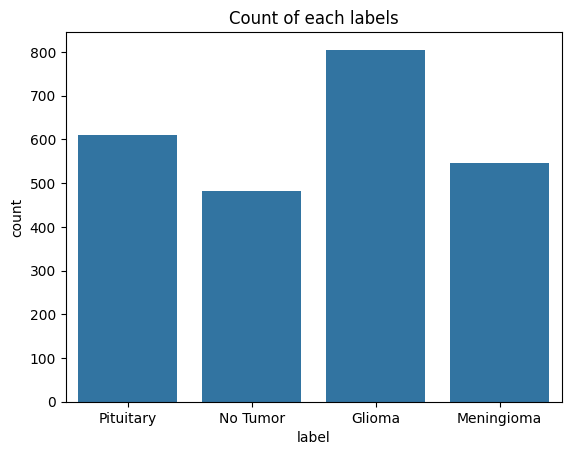

In [23]:
sns.countplot(data=df,x='label')
plt.title('Count of each labels')
plt.show()

<span style="font-size:20px">Viewing some MRI Images</span>

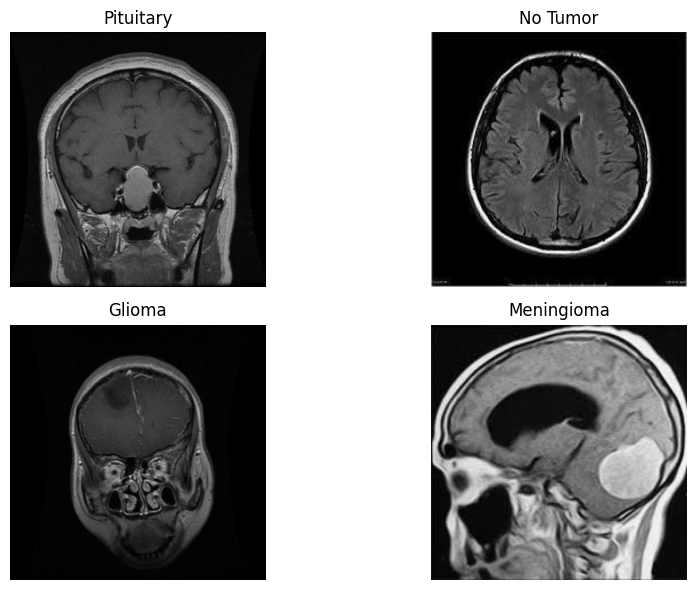

In [27]:
from PIL import Image
plt.figure(figsize=(10, 6))
for i, label in enumerate(df['label'].unique()):
    img_name = df[df['label'] == label].iloc[0]['filename']
    img_path = os.path.join("img", img_name)
    img = Image.open(img_path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

<span style="font-size:20px">Train Test and Validation Dataset splitting</span>

In [85]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 1764, Validation: 312, Test: 367


 <span style="font-size:20px">Image Data Augmentation Setup for Brain Tumor Classification</span>

In [87]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)



The code defines image preprocessing pipelines using `ImageDataGenerator`. For training data (`train_aug`), it applies various augmentations like rotation, shifting, zooming, and flipping to artificially increase data diversity and help the model generalize better. For validation (`val_aug`) and test (`test_aug`) data, it only rescales pixel values to a 0–1 range to ensure clean evaluation without altering the original image.


<span style="font-size:20px">Image Data Generators for Model Training</span>

In [89]:
target_size = (224, 224)
batch_size = 32

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    directory='img',
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    directory='img',
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True
)

test_gen = test_aug.flow_from_dataframe(
    dataframe=test_df,
    directory='img',
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=target_size,
    batch_size=1,
    shuffle=False
)


Found 1764 validated image filenames belonging to 4 classes.
Found 312 validated image filenames belonging to 4 classes.
Found 367 validated image filenames belonging to 4 classes.


This code block sets up three image data generators — train_gen, val_gen, and test_gen — using TensorFlow's flow_from_dataframe() method. It loads image files from the 'img' directory based on filenames listed in the train_df, val_df, and test_df DataFrames. Each image is resized to 224x224 pixels, and labels (from the label column) are one-hot encoded via class_mode='categorical'.

train_gen applies data augmentation (via train_aug) to improve model robustness and prevent overfitting.

val_gen and test_gen use only rescaling (via val_aug and test_aug) to ensure that model evaluation is done on unaltered data.

batch_size determines how many images are fed into the model at a time, and shuffling is enabled for training and validation but disabled for testing to preserve order for evaluation.

<span style="font-size:20px">Importing some more libraries</span>

In [91]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


<span style="font-size:20px">Custom CNN Model Architecture</span>

In [93]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_custom_cnn()
cnn_model.summary()


C:\Users\KIIT\anaconda3\envs\tf39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

The function build_custom_cnn() defines a simple custom Convolutional Neural Network (CNN) using TensorFlow's Sequential API. It is designed for classifying brain MRI images into 4 tumor categories. Here's what each part does:

Conv2D layers extract spatial features using 32 and 64 filters with ReLU activation.

MaxPooling2D layers downsample the feature maps to reduce spatial dimensions.

Flatten() converts the 2D feature maps into a 1D vector.

A Dense(128) layer learns high-level features, followed by a Dropout(0.5) layer to prevent overfitting.

The final Dense(num_classes, activation='softmax') layer outputs class probabilities for 4 tumor types.

The model is compiled using the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.
Finally, cnn_model.summary() prints the full layer-wise architecture.

<span style="font-size:20px">ResNet50-Based Transfer Learning Model</span>

In [95]:
def build_resnet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet_model()
resnet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

The function build_resnet_model() sets up a transfer learning pipeline using the ResNet50 architecture as a feature extractor. Here's a breakdown of what the model does:

ResNet50(weights='imagenet', include_top=False, ...) loads the pretrained ResNet50 model without its top classification layers. It uses ImageNet weights for feature extraction.

base_model.trainable = False freezes all layers of ResNet50 to retain learned features and avoid altering them during initial training.

GlobalAveragePooling2D() reduces feature maps into a single vector per image.

A Dense(128) layer followed by Dropout(0.5) adds learnable parameters while helping prevent overfitting.

The final Dense(num_classes, activation='softmax') layer outputs probabilities for the 4 tumor classes.

The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the metric.

This architecture is efficient for small datasets where deep feature extraction is crucial for high accuracy.

<span style="font-size:20px">MobileNetV2-Based Transfer Learning Model</span>

In [96]:
def build_mobilenet_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet_model()
mobilenet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

he function build_mobilenet_model() constructs a brain tumor classification model using MobileNetV2, a lightweight and efficient convolutional neural network optimized for mobile and embedded vision applications.

Key Components:
MobileNetV2(weights='imagenet', include_top=False, ...):
Loads a pretrained MobileNetV2 model without the top classification layer, using weights from ImageNet to leverage learned visual features.

base_model.trainable = False:
Freezes the pretrained layers so they are not updated during initial training. This helps prevent overfitting and speeds up convergence.

GlobalAveragePooling2D():
Converts the feature maps into a single vector for each image, reducing dimensionality.

Dense(128, activation='relu') + Dropout(0.5):
Adds a fully connected layer with ReLU activation and dropout regularization to learn task-specific features.

Dense(4, activation='softmax'):
Final output layer with 4 neurons corresponding to the 4 tumor classes, using softmax for multi-class classification.

Compilation:
Uses the Adam optimizer and categorical cross-entropy loss for training on one-hot encoded labels, tracking accuracy as a performance metric.

This model is particularly useful when you need fast and resource-efficient inference, especially for real-time or mobile applications.

<span style="font-size:20px">InceptionV3-Based Transfer Learning Model</span>

In [99]:
def build_inception_model(input_shape=(224, 224, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

inception_model = build_inception_model()
inception_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,572 (84.17 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

The function build_inception_model() builds a deep learning model for brain tumor classification using InceptionV3, a powerful convolutional neural network known for its architectural efficiency and high performance in image recognition tasks.

Key Components:
InceptionV3(weights='imagenet', include_top=False, ...):
Loads the pretrained InceptionV3 model (excluding its original classifier), initialized with ImageNet weights. This allows the model to utilize rich feature representations learned from millions of natural images.

base_model.trainable = False:
Freezes the base layers to retain learned features and avoid updating them during initial training.

GlobalAveragePooling2D():
Reduces the spatial dimensions of the output from the base model into a compact feature vector, lowering the number of parameters.

Dense(128, activation='relu'):
Fully connected layer for learning non-linear combinations of the features extracted by InceptionV3.

Dropout(0.5):
Prevents overfitting by randomly dropping 50% of the neurons during training.

Dense(4, activation='softmax'):
Output layer for multi-class classification, with 4 neurons corresponding to the four tumor types.

Model Compilation:
Uses Adam optimizer and categorical_crossentropy loss with accuracy as the evaluation metric, suitable for multi-class classification on one-hot encoded labels.

This architecture is ideal when you need a high-accuracy model with the power of a deeper network like InceptionV3, especially for medical imaging problems such as tumor detection.

<span style="font-size:20px">Callbacks for Model Training</span>

In [101]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]


<span style="font-size:20px">Training CNN and resnet model</span>

In [103]:
history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)
cnn_model.save("cnn_model.h5")
history_resnet = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)
resnet_model.save("resnet_model.h5")

C:\Users\KIIT\anaconda3\envs\tf39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3697 - loss: 1.8341

56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.3710 - loss: 1.8266 - val_accuracy: 0.5609 - val_loss: 1.0259
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5607 - loss: 1.0857

56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.5612 - loss: 1.0846 - val_accuracy: 0.7179 - val_loss: 0.8090
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5995 - loss: 0.9908

56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5997 - loss: 0.9905 - val_accuracy: 0.7564 - val_loss: 0.7689
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6654 - loss: 0.8537 - val_accuracy: 0.6827 - val_loss: 0.8129
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6422 - loss: 0.8940 - val_accuracy: 0.6955 - val_loss: 0.7972
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7143 - loss: 0.7414 - val_accuracy: 0.7019 - val_loss: 0.8526
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7062 - loss: 0.7613

56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7063 - loss: 0.7612 - val_accuracy: 0.7308 - val_loss: 0.7008
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7351 - loss: 0.7075 - val_accuracy: 0.5865 - val_loss: 1.2070
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7504 - loss: 0.6826

56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7502 - loss: 0.6827 - val_accuracy: 0.7212 - val_loss: 0.6861
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7541 - loss: 0.6554 - val_accuracy: 0.6474 - val_loss: 0.9898
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7378 - loss: 0.6925

56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7380 - loss: 0.6919 - val_accuracy: 0.7724 - val_loss: 0.6384
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7551 - loss: 0.6333 - val_accuracy: 0.7500 - val_loss: 0.6945
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7688 - loss: 0.5867 - val_accuracy: 0.7756 - val_loss: 0.6423
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7719 - loss: 0.6173

56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7718 - loss: 0.6175 - val_accuracy: 0.7660 - val_loss: 0.6194
Epoch 15/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7780 - loss: 0.5940 - val_accuracy: 0.7628 - val_loss: 0.6195
Epoch 16/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7980 - loss: 0.5563

56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7976 - loss: 0.5569 - val_accuracy: 0.7660 - val_loss: 0.6175
Epoch 17/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7608 - loss: 0.6335 - val_accuracy: 0.7500 - val_loss: 0.7878
Epoch 18/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8092 - loss: 0.5323 - val_accuracy: 0.7532 - val_loss: 0.7052
Epoch 19/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7930 - loss: 0.5611 - val_accuracy: 0.7692 - val_loss: 0.6503
Epoch 20/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7927 - loss: 0.5728 - val_accuracy: 0.7147 - val_loss: 0.8418


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.3216 - loss: 1.4796 - val_accuracy: 0.4359 - val_loss: 1.2429
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.3982 - loss: 1.2949 - val_accuracy: 0.5897 - val_loss: 1.1641
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.4616 - loss: 1.2122 - val_accuracy: 0.4519 - val_loss: 1.1852
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.4790 - loss: 1.1835 - val_accuracy: 0.5385 - val_loss: 1.1836
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.4734 - loss: 1.1866 - val_accuracy: 0.5096 - val_loss: 1.1178
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.4707 - loss: 1.1746 - val_accuracy: 0.4968 - val_loss: 1.1422
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.5095 - loss: 1.1585 - val_accuracy: 0.5962 - val_loss: 1.0879
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.5216 - loss: 1.1439 - val_accuracy: 0.5897 - v

<span style="font-size:20px">Training mobilenet model</span>

In [104]:
history_mobilenet = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)
inception_model.save("inception_model.h5")

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5750 - loss: 1.1531

56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5770 - loss: 1.1475 - val_accuracy: 0.8013 - val_loss: 0.4914
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7990 - loss: 0.5036

56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7992 - loss: 0.5037 - val_accuracy: 0.8173 - val_loss: 0.4307
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8412 - loss: 0.4340 - val_accuracy: 0.8141 - val_loss: 0.4593
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8398 - loss: 0.4092

56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8399 - loss: 0.4090 - val_accuracy: 0.8237 - val_loss: 0.4256
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8708 - loss: 0.3531 - val_accuracy: 0.8013 - val_loss: 0.5632
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8888 - loss: 0.3396 - val_accuracy: 0.8301 - val_loss: 0.4915
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8730 - loss: 0.3498

56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8731 - loss: 0.3493 - val_accuracy: 0.8429 - val_loss: 0.3731
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8896 - loss: 0.3070 - val_accuracy: 0.8462 - val_loss: 0.4186
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8806 - loss: 0.2886 - val_accuracy: 0.8462 - val_loss: 0.4295
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9069 - loss: 0.2712 - val_accuracy: 0.8494 - val_loss: 0.4185
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8916 - loss: 0.2936 - val_accuracy: 0.8365 - val_loss: 0.4199
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9114 - loss: 0.2224 - val_accuracy: 0.8558 - val_loss: 0.3874


<span style="font-size:20px">Training inception model</span>

In [105]:
history_inception = inception_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)
mobilenet_model.save("mobilenet_model.h5")


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.5176 - loss: 1.2677 - val_accuracy: 0.7756 - val_loss: 0.5447
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.7309 - loss: 0.7111 - val_accuracy: 0.8237 - val_loss: 0.4735
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.7734 - loss: 0.5921 - val_accuracy: 0.8205 - val_loss: 0.4235
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.7625 - loss: 0.5859 - val_accuracy: 0.8462 - val_loss: 0.4187
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.7831 - loss: 0.5725 - val_accuracy: 0.8494 - val_loss: 0.3993
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8150 - loss: 0.5167

56/56 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8149 - loss: 0.5164 - val_accuracy: 0.8718 - val_loss: 0.3400
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8118 - loss: 0.4903 - val_accuracy: 0.8686 - val_loss: 0.3569
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8460 - loss: 0.4343 - val_accuracy: 0.8526 - val_loss: 0.3656
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8212 - loss: 0.4610

56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.8213 - loss: 0.4610 - val_accuracy: 0.8750 - val_loss: 0.3220
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8430 - loss: 0.4415 - val_accuracy: 0.8558 - val_loss: 0.3441
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8480 - loss: 0.3947

56/56 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.8478 - loss: 0.3952 - val_accuracy: 0.9006 - val_loss: 0.2922
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8487 - loss: 0.4142

56/56 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.8487 - loss: 0.4138 - val_accuracy: 0.8750 - val_loss: 0.2787
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.8311 - loss: 0.4287 - val_accuracy: 0.8365 - val_loss: 0.3672
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8365 - loss: 0.3960 - val_accuracy: 0.8782 - val_loss: 0.3030
Epoch 15/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.8657 - loss: 0.3631 - val_accuracy: 0.8846 - val_loss: 0.2964
Epoch 16/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8508 - loss: 0.3660 - val_accuracy: 0.8686 - val_loss: 0.2976
Epoch 17/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8402 - loss: 0.4219

56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.8404 - loss: 0.4215 - val_accuracy: 0.8846 - val_loss: 0.2764
Epoch 18/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8592 - loss: 0.3845

56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8591 - loss: 0.3844 - val_accuracy: 0.9006 - val_loss: 0.2634
Epoch 19/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.8529 - loss: 0.3889 - val_accuracy: 0.8942 - val_loss: 0.2935
Epoch 20/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8613 - loss: 0.3623

56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.8613 - loss: 0.3625 - val_accuracy: 0.9071 - val_loss: 0.2376


<span style="font-size:20px">Resnet Classification Report and Condusion matrix</span>

C:\Users\KIIT\anaconda3\envs\tf39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


367/367 ━━━━━━━━━━━━━━━━━━━━ 121s 307ms/step
Classification Report (ResNet50):
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       131
           1       0.50      0.35      0.41        75
           2       0.61      0.77      0.68        66
           3       0.72      0.60      0.66        95

    accuracy                           0.67       367
   macro avg       0.64      0.64      0.63       367
weighted avg       0.66      0.67      0.66       367



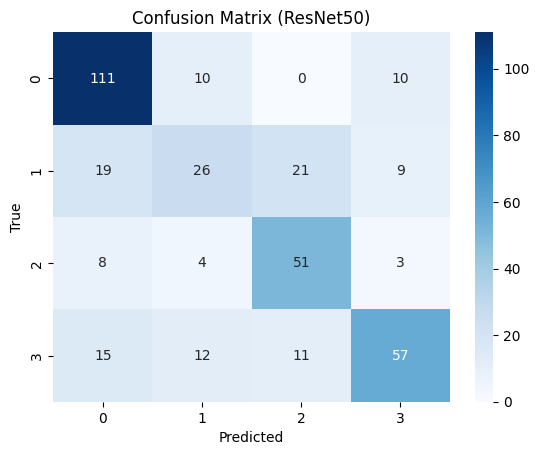

In [59]:
# ResNet Predictions
resnet_preds = resnet_model.predict(test_gen)
resnet_y_pred = np.argmax(resnet_preds, axis=1)
resnet_y_true = test_gen.classes  # ground truth from generator

# Classification Report (ResNet)
print("Classification Report (ResNet50):")
print(classification_report(resnet_y_true, resnet_y_pred))

# Confusion Matrix (ResNet)
conf_mat = confusion_matrix(resnet_y_true, resnet_y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [63]:
# Predict probabilities
preds_cnn = cnn_model.predict(test_gen)

# True labels as integers
y_true_labels = test_df['label'].map({
    'Glioma': 0, 
    'Meningioma': 1, 
    'No Tumor': 2, 
    'Pituitary': 3
}).values

# Predicted class indices
y_pred_labels = np.argmax(preds_cnn, axis=1)


367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step


<span style="font-size:20px">Custom CNN Classification Report and Condusion matrix</span>

In [65]:
from sklearn.metrics import classification_report

target_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

print("Custom CNN Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))


Custom CNN Classification Report:
              precision    recall  f1-score   support

      Glioma       0.78      0.94      0.85       131
  Meningioma       0.58      0.20      0.30        75
    No Tumor       0.81      0.82      0.81        66
   Pituitary       0.74      0.92      0.82        95

    accuracy                           0.76       367
   macro avg       0.73      0.72      0.70       367
weighted avg       0.73      0.76      0.72       367



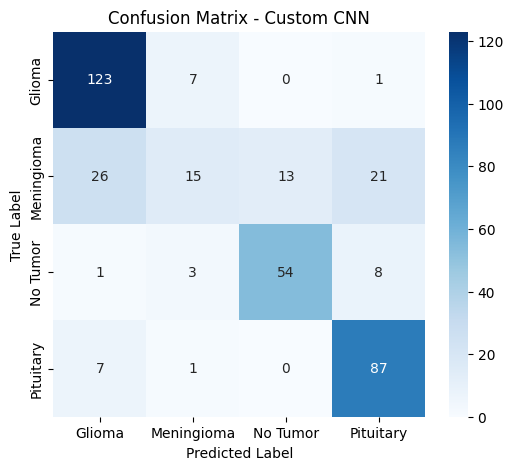

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)

plt.title("Confusion Matrix - Custom CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<span style="font-size:20px">Function for fiiting and getting classification report and confusion matrix for a model</span>

In [47]:
def evaluate_model(model, name):
    # Predict
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)

    # Ground truth
    y_true = test_df['label'].map({
        'Glioma': 0,
        'Meningioma': 1,
        'No Tumor': 2,
        'Pituitary': 3
    }).values

    # Classification Report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
                yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


<span style="font-size:20px">Fitting MobileNetV2 and InceptionV3 and getting their classification Report</span>

C:\Users\KIIT\anaconda3\envs\tf39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


367/367 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step

MobileNetV2 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.96      0.86      0.91       131
  Meningioma       0.75      0.77      0.76        75
    No Tumor       0.91      0.94      0.93        66
   Pituitary       0.88      0.97      0.92        95

    accuracy                           0.89       367
   macro avg       0.88      0.89      0.88       367
weighted avg       0.89      0.89      0.89       367



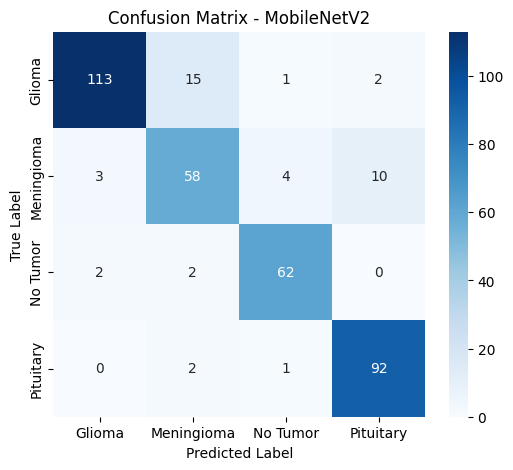

367/367 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step

InceptionV3 Classification Report:
              precision    recall  f1-score   support

      Glioma       0.96      0.93      0.95       131
  Meningioma       0.84      0.79      0.81        75
    No Tumor       0.90      0.94      0.92        66
   Pituitary       0.89      0.95      0.92        95

    accuracy                           0.91       367
   macro avg       0.90      0.90      0.90       367
weighted avg       0.91      0.91      0.91       367



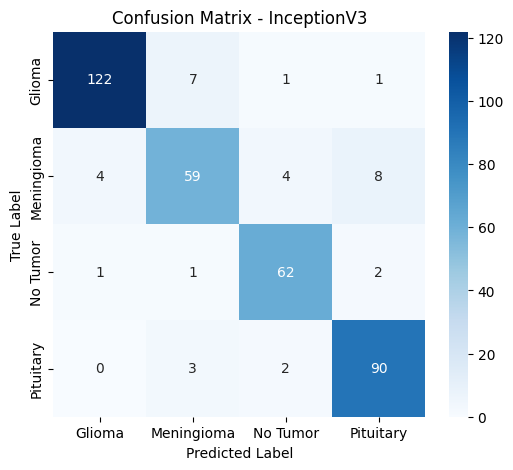

In [49]:
evaluate_model(mobilenet_model, "MobileNetV2")
evaluate_model(inception_model, "InceptionV3")


<span style="font-size:20px">Validation Accuracy comparison of models</span>

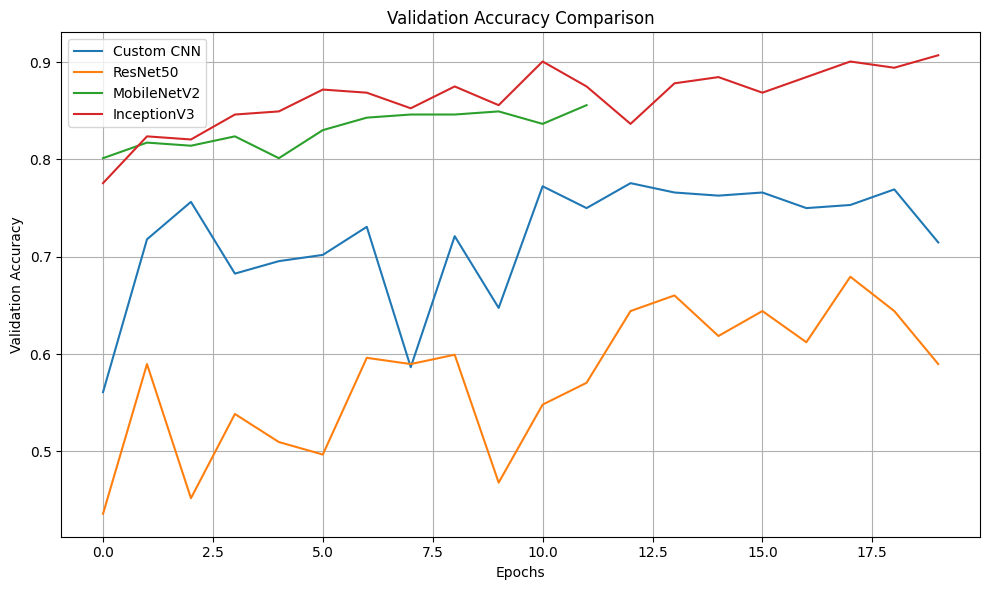

In [109]:
import matplotlib.pyplot as plt

# Plot validation accuracy for all 4 models
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['val_accuracy'], label='Custom CNN')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNetV2')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3')

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<span style="font-size:25px; font-weight:bold">Conclusion</span>


In this project, we built and compared multiple deep learning models—including a custom CNN, ResNet50, MobileNetV2, and InceptionV3—to classify brain MRI images into four tumor types: **Glioma**, **Meningioma**, **Pituitary**, and **No Tumor**. We used transfer learning for pre-trained models and data augmentation to improve generalization. Among the models, **transfer learning approaches (especially ResNet50 and InceptionV3)** generally achieved better accuracy and robustness than the custom CNN. The evaluation through classification reports and confusion matrices helped identify model strengths and weaknesses, providing a strong foundation for medical image classification task.
